#  Magical Machine Learning - An Interactive approach

### If you don't know what is Machine Learning. Here's a very brief inroduction for you from Google :)

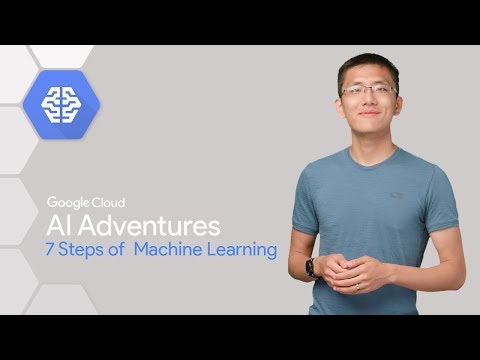

In [70]:
from IPython.lib.display import YouTubeVideo
vid = YouTubeVideo('nKW8Ndu7Mjw')
display(vid)

### We'll try to generate our own random data with two classes say 'Beer' or 'Wine' and two features say 'Alcohol' and 'Color Intensity'. Then we'll try train our Machine learning model on this data for predicting the class on unseen test data

##### First Let's Import necessary libraries

In [39]:
from ipywidgets import interact, interactive, IntSlider, Layout
import ipywidgets as widgets
from IPython.display import display

print(__doc__)


import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model.logistic import LogisticRegressionCV

Automatically created module for IPython interactive environment


## Classficiation using Logistic Regression and SVM

### Function definition generating data points with noise and classifying

#### Let us First define some esssential function. 
#### Note: You need not pay heed to the code as its just a syntatic sugar and will be explained in the workshop

In [9]:
def store(change=None):
    x1 = scatter_plot.x
    x2 = scatter_plot.y
    xl,yl,ynl,x1l,x2l = pl.result
    dic = {'X1':x1,'X2':x2,'out':ynl}
    store.df = pd.DataFrame(data=dic)
    store.df['y']=store.df['out'].apply(lambda x:int(x>0))
    print('Updated')

In [51]:
def func_log(N_samples,x_min,x_max,noise_magnitude,noise_sd,noise_mean):
    
    """
    ================================
            DATA GENERATION
    ================================

    Input:  Number of Samples, minimum value, maximum value,
            noise magnitude, noise standard deviation, noise mean
    Output: Data comprising x range, y range, target , feature_1, feature_2
    """
    
    from bqplot import pyplot as plt
    x= np.linspace(x_min,x_max,N_samples*5)
    x1= np.random.choice(x,size=N_samples)
    x2= np.random.choice(x,size=N_samples)
    y=1.5*x1-2*x2
    yn= y+noise_magnitude*np.random.normal(loc=noise_mean,scale=noise_sd,size=N_samples)
    
    plt.figure(figsize=(20,10), title="Data", fig_margin=dict(top=50, bottom=70, left=120, right=120) )
    c = ['negative class' if i < 0 else 'positive class' for i in y]

    plt.scales(scales={'color': OrdinalColorScale(colors=['DodgerBlue','OrangeRed'])})
    axes_options = {'x': dict(label='feature_1', label_location='end'),
                'y': dict(label='feature_2'),
                'color': dict(label='Class', side='right')
               }
    global scatter_plot
    scatter_plot = plt.scatter(x1,x2, color = c,
                stroke='black',
                axes_options=axes_options)
    plt.show()
    scatter_plot.enable_move = True
    scatter_plot.observe(store, 'y')
    return (np.array(x),np.array(y),np.array(yn),np.array(x1),np.array(x2))

In [52]:
def plot_data(change=0):
    global pl
    pl=interactive(func_log,N_samples={'Low (50 samples)':50,'Medium (100 samples)':100,'High (200 samples)':200},x_min=(-10,0,1), x_max=(0,10,1),
                  noise_magnitude=(0,5,1),noise_sd=(0.1,1,0.1),noise_mean=(-2,2,0.5))
    display(pl)

### Plot and interactively control the data points by calling the plot_data function

##### Execute the following cell (Shift + Enter) and play with the scroll bars. 

In [53]:
plot_data()

interactive(children=(Dropdown(description='N_samples', options={'Low (50 samples)': 50, 'Medium (100 samples)': 100, 'High (200 samples)': 200}, value=50), IntSlider(value=-5, description='x_min', max=0, min=-10), IntSlider(value=5, description='x_max', max=10), IntSlider(value=2, description='noise_magnitude', max=5), FloatSlider(value=0.5, description='noise_sd', max=1.0, min=0.1), FloatSlider(value=0.0, description='noise_mean', max=2.0, min=-2.0, step=0.5), Output()), _dom_classes=('widget-interact',))

### Store the generated data

In [59]:
try:
    data = store.df.copy()
except AttributeError as e:
    xl,yl,ynl,x1l,x2l = pl.result
    dic = {'X1':x1l,'X2':x2l,'out':ynl}
    data = pd.DataFrame(data=dic)
    data['y']=data['out'].apply(lambda x: int(x>0))

### Logistic regression  and SVM encapsulated within a function

In [67]:
import matplotlib.pyplot as plt
def log_fit(Model,C,test_size,penalty):
    """
    ================================
            MODEL FITTING
    ================================

    Input:  Model(String), regularization param, test/train ratio,
            L1/L2 Penalty
    Output: Train score, Test score
    """
    
    X_train, X_test, y_train, y_test = train_test_split(data[['X1','X2']],data['y'],test_size=test_size,random_state=101)
    
    df_test=pd.DataFrame(X_test,columns=['X1','X2'])
    df_test['y']=y_test
    
    df_train=pd.DataFrame(X_train,columns=['X1','X2'])
    df_train['y']=y_train
    if Model == 'Logistic':
        if (penalty=='L1 norm'):
            logm = LogisticRegressionCV(Cs=[np.power(10,-C)],penalty='l1',solver='saga')
        if (penalty=='L2 norm'):
            logm = LogisticRegressionCV(Cs=[np.power(10,-C)],penalty='l2',solver='lbfgs')
    else:
        logm = SVC(kernel="linear", C=np.power(10,-C), probability=True)
    
    logm.fit(X_train,y_train)
    
    train_score = logm.score(X_train,y_train)
    test_score = logm.score(X_test,y_test)
    
    xx, yy = np.mgrid[-10:10:.01, -10:10:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = logm.predict_proba(grid)[:, 1].reshape(xx.shape)
        
    c_test = [i for i in df_test['y']]
    c_train = [i for i in df_train['y']]
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,8))
    contour = ax[0].contourf(xx, yy, probs, 25, cmap="RdBu",vmin=0, vmax=1)
    ax1_c = f.colorbar(contour)
    ax1_c.set_label("$Prob\ (y = 1)$",fontsize=15)
    ax1_c.set_ticks([0, .25, .5, .75, 1])
    ax[0].set_xlabel("$X_1$",fontsize=15)
    ax[0].set_ylabel("$X_2$",fontsize=15)
    ax[0].contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=0.6,lw=3)
    
    ax[0].scatter(df_test['X1'],df_test['X2'],c=c_test,edgecolors='k',s=100)
    ax[0].set_title("\nTest score: %.3f\n"%(test_score),fontsize=20)
    
    contour = ax[1].contourf(xx, yy, probs, 25, cmap="RdBu",vmin=0, vmax=1)

    ax[1].set_xlabel("$X_1$",fontsize=15)
    ax[1].set_ylabel("$X_2$",fontsize=15)
    ax[1].contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=0.6,lw=3)
    
    ax[1].scatter(df_train['X1'],df_train['X2'],c=c_train,edgecolors='k',s=100)
    ax[1].set_title("\nTraining score: %.3f\n"%(train_score),fontsize=20)
        
    plt.grid(True)
    plt.tight_layout()
    plt.show()
      
    return (train_score,test_score)    

### Run the encapsulated ML function with ipywidget interactive
#### Simply execute the following cell (Shift +Enter) and play with the scroll bars.

In [69]:
from ipywidgets import HBox, Label, FloatSlider

style = {'description_width': 'initial'}

lb1=Label (value="Play with options and watch the probability space evolve dynamically. \
Remember, smaller the value of $C$, stronger the regularization strength",fontsize=15)

logp=interactive(log_fit,Model = {'Logistic','SVM'},C=FloatSlider(value=0,min=0,max=2,step=0.1,
                                       description='Regularization ($10^{-C}$), $C$', style=style,continuous_update=False),
                 test_size=FloatSlider(value=0.1,min=0.1,max=0.5,step=0.1,
                                       description = 'Test fraction ($X_{test}$)', style=style),
                penalty=widgets.RadioButtons(options=["L1 norm","L2 norm"], description = 'Penalty norm'))

# Set the height of the control.children[-1] so that the output does not jump and flicker
output = logp.children[-1]
output.layout.height = '700px'
output.layout.width = '1020px'

display(lb1)
display(logp)

Label(value='Play with options and watch the probability space evolve dynamically. Remember, smaller the value of $C$, stronger the regularization strength')

interactive(children=(Dropdown(description='Model', options=('Logistic', 'SVM'), value='Logistic'), FloatSlider(value=0.0, continuous_update=False, description='Regularization ($10^{-C}$), $C$', max=2.0, style=SliderStyle(description_width='initial')), FloatSlider(value=0.1, description='Test fraction ($X_{test}$)', max=0.5, min=0.1, style=SliderStyle(description_width='initial')), RadioButtons(description='Penalty norm', options=('L1 norm', 'L2 norm'), value='L1 norm'), Output(layout=Layout(height='700px', width='1020px'))), _dom_classes=('widget-interact',))